In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

# Regression Analysis: Seasonal Effects with Sklearn Linear Regression
In this notebook, you will build a SKLearn linear regression model to predict Yen futures ("settle") returns with *lagged* Yen futures returns. 

In [2]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(
    Path("yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [3]:
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


# Data Preparation

### Returns

In [11]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
# YOUR CODE HERE!
yen_futures['Return'] = yen_futures[["Settle"]].pct_change() * 100
yen_futures['Return'] = yen_futures['Return'].replace(-np.inf, np.nan).dropna()
yen_futures.tail()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest,Return,Lagged_Return
Date,,,,,,,,,,
2019-10-09,9381.0,9391.5,9330.5,9343.5,38.5,9338.0,99153.0,145470.0,-0.410601,0.170931
2019-10-10,9343.5,9380.5,9293.5,9301.0,34.5,9303.5,159397.0,144474.0,-0.369458,-0.410601
2019-10-11,9308.5,9309.0,9240.0,9267.0,52.5,9251.0,158810.0,147471.0,-0.564304,-0.369458
2019-10-14,9259.0,9292.0,9250.5,9261.0,14.0,9265.0,69457.0,153902.0,0.151335,-0.564304
2019-10-15,9264.5,9280.0,9216.5,9220.0,43.5,9221.5,108342.0,151564.0,-0.469509,0.151335


### Lagged Returns 

In [24]:
# Create a lagged return using the shift function
# YOUR CODE HERE!
yen_futures['Lagged_Return'] = yen_futures.Return.shift()
yen_futures.tail()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest,Return,Lagged_Return
Date,,,,,,,,,,
2019-10-09,9381.0,9391.5,9330.5,9343.5,38.5,9338.0,99153.0,145470.0,-0.410601,0.170931
2019-10-10,9343.5,9380.5,9293.5,9301.0,34.5,9303.5,159397.0,144474.0,-0.369458,-0.410601
2019-10-11,9308.5,9309.0,9240.0,9267.0,52.5,9251.0,158810.0,147471.0,-0.564304,-0.369458
2019-10-14,9259.0,9292.0,9250.5,9261.0,14.0,9265.0,69457.0,153902.0,0.151335,-0.564304
2019-10-15,9264.5,9280.0,9216.5,9220.0,43.5,9221.5,108342.0,151564.0,-0.469509,0.151335


### Train Test Split

In [33]:
# Create a train/test split for the data using 2018-2019 for testing and the rest for training
train = yen_futures['2014':'2018']
test = yen_futures['2018':]

In [38]:
# Create four dataframes:
# X_train (training set using just the independent variables), X_test (test set of of just the independent variables)
# Y_train (training set using just the "y" variable, i.e., "Futures Return"), Y_test (test set of just the "y" variable):
# YOUR CODE HERE!
X_train = train["Lagged_Return"].to_frame()
X_test = test["Lagged_Return"].to_frame()
y_train = train["Return"]
y_test = test["Return"]

In [39]:
X_train, y_train

(            Lagged_Return
 Date                     
 2014-01-02      -0.157596
 2014-01-03       0.547196
 2014-01-06       0.031397
 2014-01-07       0.376648
 2014-01-08      -0.218887
 ...                   ...
 2018-12-24      -0.187545
 2018-12-26       0.834485
 2018-12-27      -0.893346
 2018-12-28       0.464525
 2018-12-31       0.297242
 
 [1258 rows x 1 columns],
 Date
 2014-01-02    0.547196
 2014-01-03    0.031397
 2014-01-06    0.376648
 2014-01-07   -0.218887
 2014-01-08   -0.302935
                 ...   
 2018-12-24    0.834485
 2018-12-26   -0.893346
 2018-12-27    0.464525
 2018-12-28    0.297242
 2018-12-31    0.664069
 Name: Return, Length: 1258, dtype: float64)

# Linear Regression Model

In [40]:
# Create a Linear Regression model and fit it to the training data
from sklearn.linear_model import LinearRegression

# Fit a SKLearn linear regression using just the training set (X_train, Y_train):
# YOUR CODE HERE!
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression()

# Make predictions using the Testing Data

Note: We want to evaluate the model using data that it has never seen before, in this case: X_test.

In [42]:
# Make a prediction of "y" values using just the test dataset
# YOUR CODE HERE!
predictions = lr_model.predict(X_test)

In [44]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
# YOUR CODE HERE!
results = y_test.to_frame()
results["Predicted_Return"] = predictions
results.head()

,Return,Predicted_Return
Date,,
2018-01-02,0.297285,-0.004717
2018-01-03,-0.240479,-0.005830
2018-01-04,-0.213028,0.002433
2018-01-05,-0.353933,0.002011
2018-01-08,0.062017,0.004176


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001D7BBB80D48>,
      dtype=object)

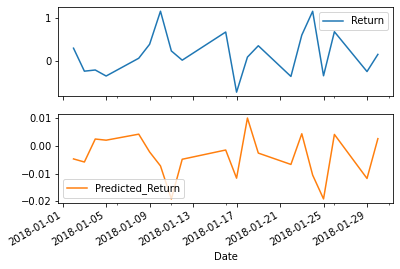

In [47]:
# Plot the first 20 predictions vs the true values
# YOUR CODE HERE!
results[:20].plot(subplots=True)

**Notes: Trend lines above are similar, however value ranges are very different (shown more easily with .plot(subplots=False)**

# Out-of-Sample Performance

Evaluate the model using "out-of-sample" data (X_test and y_test)

In [52]:
from sklearn.metrics import mean_squared_error
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
# YOUR CODE HERE!
m_sq_err = mean_squared_error(results["Return"], results["Predicted_Return"])

# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
# YOUR CODE HERE!
root_m_sq_err = np.sqrt(m_sq_err)
print(f'Out-of-sample RMSE: {root_m_sq_err}')

Out-of-sample RMSE: 0.41367669313524336


# In-Sample Performance

Evaluate the model using in-sample data (X_train and y_train)

In [51]:
# Construct a dataframe using just the "y" training data:
# YOUR CODE HERE!
in_sample_results = y_train.to_frame()

# Add a column of "in-sample" predictions to that dataframe:  
# YOUR CODE HERE!
in_sample_results["In-sample_Predictions"] = lr_model.predict(X_train)

# Calculate in-sample mean_squared_error (for comparison to out-of-sample)
# YOUR CODE HERE!
in_sample_m_sq_err = mean_squared_error(
    in_sample_results["Return"],
    in_sample_results["In-sample_Predictions"]
)

# Calculate in-sample root mean_squared_error (for comparison to out-of-sample)
# YOUR CODE HERE!
in_sample_root_m_sq_err = np.sqrt(in_sample_m_sq_err)

print(f'In-sample root mean squared error: {in_sample_root_m_sq_err}')

In-sample root mean squared error: 0.565021989417302


# Conclusions

YOUR CONCLUSIONS HERE!

Does this model perform better or worse on out-of-sample data compared to in-sample data?

**Answer:**    
In-sample root mean squared error (RMSE) is ~0.57 and Out-of-sample RMSE is ~0.41.

Based on the in-sample RMSE being greater than out-of-sample,  this model performs better on the out-of-sample data than the in-sample data.**